# Location identification
## Baseline model

**Objective**: 

The main goal of this project predict the location of an user based on the RSSI signals from different beacons.

The RSSI was taken every 100 ms.

## Data Exploration
### 1. Loading libraries

In [1]:
import glob2 as glob
import re
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
pd.option_context("display.max_columns", None)

### 2. Loading data

In [40]:
orig_df = pd.read_csv('/content/drive/MyDrive/Research/IBM Advanced Data Science/test_DF.csv')
orig_df = orig_df[orig_df['user_at'].isin(['study', 'kitchen', 'main', 'living'])]
orig_df.head()


,Sr No,Timestamp,Device Name,MAC Address,RSSI,Raw Data,Battery,Ambient Temperature,user_at,file_id,beacon_at,Timestamp2
0,2,2021-08-17 06:39:39.918,BrtBeacon402,C2:65:7C:E2:D6:6B,-59,-,21,170.1 Deg C,study,1,study,2021-08-17 06:39:40.000
1,5,2021-08-17 06:39:39.967,BMPkitchen,80:EC:CA:CD:2F:42,-81,1a4c0002150112233445566778899aabbccddeeff02716...,-,-,study,1,kitchen,2021-08-17 06:39:40.000
2,7,2021-08-17 06:39:40.027,BrtBeacon402,C2:65:7C:E2:D6:6B,-59,-,21,170.1 Deg C,study,1,study,2021-08-17 06:39:40.000
3,8,2021-08-17 06:39:40.059,BrtBeacon402,D9:C7:16:15:A3:0F,-94,-,21,170.1 Deg C,study,1,living,2021-08-17 06:39:40.000
4,11,2021-08-17 06:39:40.131,BrtBeacon402,C2:65:7C:E2:D6:6B,-57,-,21,170.1 Deg C,study,1,study,2021-08-17 06:39:40.000


In [41]:
orig_df['file_id'].unique()
list(range(22, 31))

[22, 23, 24, 25, 26, 27, 28, 29, 30]

In [42]:
train_df_or = orig_df[orig_df['file_id'].isin(list(range(1, 22)))]
test_df_or = orig_df[orig_df['file_id'].isin(list(range(22, 31)))]

In [43]:
train_df = train_df_or.pivot_table(values='RSSI', index=['user_at', 'file_id', 'Timestamp'], columns='beacon_at', aggfunc = 'median').reset_index()
train_df["kitchen"] = train_df['kitchen'].fillna(train_df.groupby('user_at')['kitchen'].transform('median'))
train_df["living"] = train_df['living'].fillna(train_df.groupby('user_at')['living'].transform('median'))
train_df["main"] = train_df['main'].fillna(train_df.groupby('user_at')['main'].transform('median'))
train_df["study"] = train_df['study'].fillna(train_df.groupby('user_at')['study'].transform('median'))

test_df = test_df_or.pivot_table(values='RSSI', index=['user_at', 'file_id', 'Timestamp'], columns='beacon_at', aggfunc = 'median').reset_index()
test_df["kitchen"] = test_df['kitchen'].fillna(test_df.groupby('user_at')['kitchen'].transform('median'))
test_df["living"] = test_df['living'].fillna(test_df.groupby('user_at')['living'].transform('median'))
test_df["main"] = test_df['main'].fillna(test_df.groupby('user_at')['main'].transform('median'))
test_df["study"] = test_df['study'].fillna(test_df.groupby('user_at')['study'].transform('median'))

In [44]:
print(train_df_or['user_at'].unique())
print(test_df_or['user_at'].unique())

['study' 'main' 'living' 'kitchen']
['study' 'kitchen' 'main' 'living']


In [45]:
train_df.head()

beacon_at,user_at,file_id,Timestamp,kitchen,living,main,study
0,kitchen,4,2021-08-17 07:53:48.882,-56.0,-75.0,-80.0,-70.0
1,kitchen,4,2021-08-17 07:53:48.935,-56.0,-74.0,-80.0,-67.0
2,kitchen,4,2021-08-17 07:53:48.991,-56.0,-68.0,-80.0,-70.0
3,kitchen,4,2021-08-17 07:53:49.046,-56.0,-74.0,-80.0,-68.0
4,kitchen,4,2021-08-17 07:53:49.098,-56.0,-67.0,-80.0,-70.0


In [46]:
X_train = train_df[['kitchen', 'living', 'main', 'study']]
y_train = train_df['user_at']

X_test = test_df[['kitchen', 'living', 'main', 'study']]
y_test = test_df['user_at']

## Decision tree

In [47]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix

dtree_model = DecisionTreeClassifier(max_depth = 3).fit(X_train, y_train)
dtree_pred = dtree_model.predict(X_test)

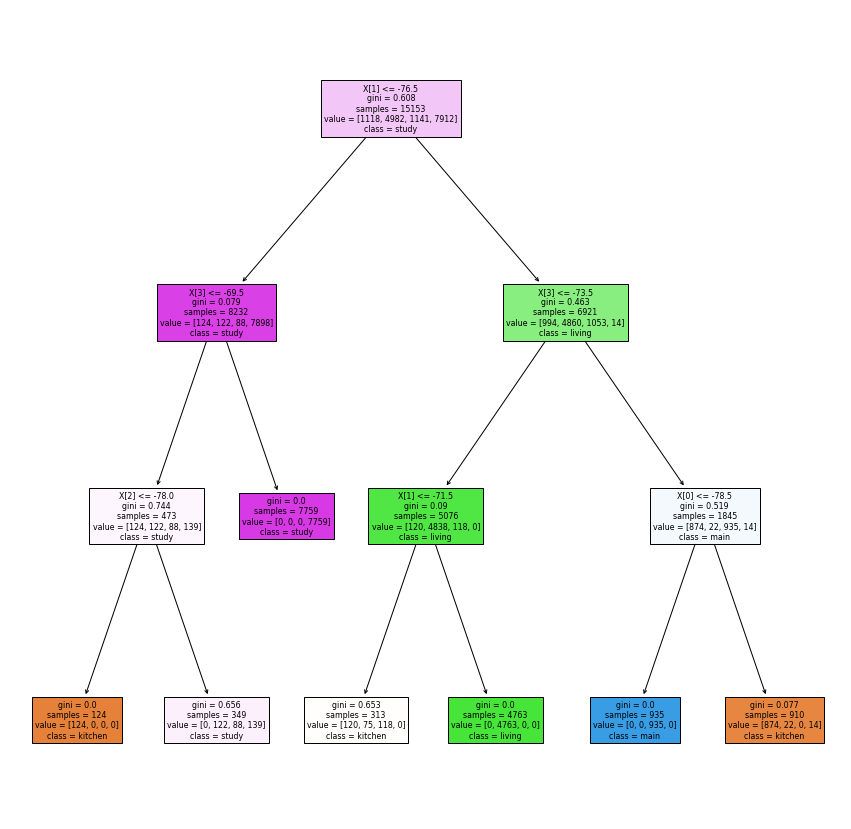

In [48]:
class_names = ['kitchen', 'living', 'main', 'study']
from sklearn import tree
plt.figure(figsize = (15, 15))
tree.plot_tree(dtree_model, class_names=class_names, filled = True)
plt.show()

In [49]:
cm = confusion_matrix(y_test, dtree_pred)
print(cm)

[[2392    0    1  214]
 [  74 2321    0   10]
 [  34    0  989   90]
 [  83    0    0 2510]]


In [50]:
y_test.value_counts()

kitchen    2607
study      2593
living     2405
main       1113
Name: user_at, dtype: int64

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

     kitchen       0.93      0.92      0.92      2607
      living       1.00      0.97      0.98      2405
        main       1.00      0.89      0.94      1113
       study       0.89      0.97      0.93      2593

    accuracy                           0.94      8718
   macro avg       0.95      0.93      0.94      8718
weighted avg       0.94      0.94      0.94      8718



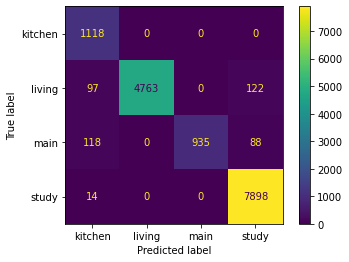

In [51]:
# creating a confusion matrix
plot_confusion_matrix(dtree_model, X_train, y_train);
print(classification_report(y_test, dtree_pred))